# Chapter 1_1 线性回归
----
author: W.Y.  
first_edition: 2019/12/31  
last_edition: 2020/1/18  
description: 王汉生老师书的第一章，线性回归的python极简实现  

----

## 导入模块

In [1]:
import pandas as pd  # NOTE。pandas模块用于读取数据、处理数据等
from numpy import mean, median, var, std  # 从模块numpy导入子模块；均值、中位数、方差、标准差
import matplotlib.pyplot as plt  # 画图模块
import matplotlib
import statsmodels.formula.api as smf  # 基于公式的统计模型API接口
import lmdiag  # 画模型诊断图的模块
from patsy import dmatrices  # NOTE。用于分析统计模型，构建矩阵（这里是为了做共线性诊断）
from statsmodels.stats.outliers_influence import variance_inflation_factor   # 用于共线性诊断

**NOTE**
>1. 导入pandas,命名为pd。通常在模块名很长时使用 import xxx as x的格式，方便简单。
>常用缩写有`import pandas as pd`, `import numpy as np`
>2. `from patsy import dmatrices`这句可能会出现`Cannot find reference`的报错，下面画红色波浪线，这算是Pycharm的bug吧，可以不管，可以正常运行

## 导入数据

In [2]:
# 导入数据之导入txt文件  # NOTE
data = pd.read_csv('E:\Data Mining\SimplePython\Chapter 1 从R到Python\CH 1_1 线性回归\CH 1_1 data.txt', sep = '\s+') # NOTE

**NOTE**
>1. 导入txt文件，常用函数有`read_csv()`, `read_table()`，主要区别是前者默认读取逗号分隔符，可指定其它分隔符，后者无默认分隔符，必须指定分隔符。
>2. 本案例的txt文件有些特殊，以多个空格分隔，且首行和其它行分隔的空格数不同，因此用正则表达式，`\s`代表空格、tab等空白字符，`\s+`代表多个空白字符 
>3. 表示路径时，理论上用`\`或者`/`都可以，但是我更建议用`/`，因为`\`也用做转义，如果文件名开头以数字或某些特殊单词开头时会出错。如果用`\`最好用`\\`
>4. 通常不建议用带有中文的路径，不管是R还是Python都是如此。不过这里我乐意~~

In [3]:
# 查看数据前10行。NOTE
data.head(10)

,year,ROEt,ATO,PM,LEV,GROWTH,PB,ARR,INV,ASSET,ROE
0,2002,0.296,0.389,0.215,4.384,0.197,8.048,0.637,0.248,20.873,0.181
1,2002,0.665,0.335,0.407,2.273,-0.084,2.154,-1.217,0.030,21.062,0.899
2,2002,-0.045,0.963,0.084,-5.339,4.155,-12.879,-0.598,0.096,21.474,1.504
3,2002,-0.783,0.437,-0.096,1.016,2.231,3.836,0.056,0.051,19.746,-0.777
4,2002,1.053,0.858,-0.154,-2.066,0.519,1.972,0.293,0.032,22.570,0.728
5,2002,0.590,0.528,0.197,-0.946,-1.441,2.405,-0.986,0.189,20.890,1.141
6,2002,-0.204,0.419,0.324,3.513,1.999,8.827,0.389,-0.060,21.965,0.568
7,2002,-0.845,0.891,0.131,4.628,1.733,7.522,-0.471,0.145,20.377,-0.171
8,2002,-0.065,-0.230,0.071,1.525,-2.436,-14.887,0.958,0.215,20.480,0.415
9,2002,1.001,-0.176,0.123,-0.891,2.257,-12.065,-0.336,0.065,20.455,0.699


In [4]:
pd.DataFrame.head(data,5)

,year,ROEt,ATO,PM,LEV,GROWTH,PB,ARR,INV,ASSET,ROE
0,2002,0.296,0.389,0.215,4.384,0.197,8.048,0.637,0.248,20.873,0.181
1,2002,0.665,0.335,0.407,2.273,-0.084,2.154,-1.217,0.030,21.062,0.899
2,2002,-0.045,0.963,0.084,-5.339,4.155,-12.879,-0.598,0.096,21.474,1.504
3,2002,-0.783,0.437,-0.096,1.016,2.231,3.836,0.056,0.051,19.746,-0.777
4,2002,1.053,0.858,-0.154,-2.066,0.519,1.972,0.293,0.032,22.570,0.728


**NOTE**

>1. 可以看看R和Python`head()`函数的差别。
>2. `data.head(10)`和`pd.DataFrame.head(data, 10)`是一样的，都是调用了pandas模块中DataFrame这个类下面的head函数。
>python中很多函数都有这两种用法，通常会用第一种。
>3. 直接用`dataframe.head()`会输出前5行，加入数字则是相应的行，比如`dataframe.head(10)`就输出前10行。

拓展
>那么为什么不输入数字是5行呢？  
>可以用`ctrl+鼠标左键点击`函数，可以看到`def head(self, n=5):`这一句源代码，也就是说函数的参数默认值是5.  
>这里是拓展知识，之后写自定义函数的时候会用到，这里想到了就简单提一下~

In [5]:
# 数据分割，2002年用来建模，2003年用来预测
# NOTE
data2002 = data[data['year'] == 2002]
data2003 = data[data['year'] == 2003]

**NOTE**
>用pandas选择数据框中的列时，用`dataframe['column_name']`，就类似R中的`dataframe$col`

## 描述性分析（描述性统计）

In [6]:
# 描述性分析，单独计算
mean_ROEt = mean(data2002['ROEt'])  # 均值
median_ATO = median(data2002['ATO'])  # 中位数
var_PM = var(data2002['PM'])  # 方差
min_LEV = min(data2002['LEV'])  # 最小值
max_GROWTH = max(data2002['GROWTH'])  # 最大值
std_PB = std(data2002['PB'])

print('mean_ROEt:', mean_ROEt, 
      '\nmedian_ATO:', median_ATO,
      '\nvar_PM:', var_PM,
      '\nmin_LEV:', min_LEV,
      '\nmax_GROWTH:', max_GROWTH,
      '\nstd_PB:', std_PB)  # note 5

mean_ROEt: 0.067778 
median_ATO: 0.4375 
var_PM: 0.032730709696000004 
min_LEV: -7.941 
max_GROWTH: 6.0920000000000005 
std_PB: 9.503158413643126


**NOTE**
>`print()`函数的用法，除了变量，其它要输出的都要用引号；输出要换行需要加入`\n`，代码中的换行只是为了好看


In [7]:
# 描述性分析，统一计算
# NOTE
df_describe = pd.concat([data2002.min(), data2002.max(),
                         data2002.median(), data2002.mean(),
                         data2002.var(), data2002.std()], axis=1)
df_describe.columns = ['min', 'max', 'median', 'mean', 'var', 'std']  # 重命名列名
df_describe.head()

,min,max,median,mean,var,std
year,2002.000,2002.000,2002.0000,2002.000000,0.000000,0.000000
ROEt,-1.390,1.421,0.0800,0.067778,0.269285,0.518927
ATO,-0.928,1.927,0.4375,0.429818,0.211972,0.460404
PM,-0.424,0.698,0.2180,0.210952,0.032796,0.181097
LEV,-7.941,9.362,0.5595,0.708852,10.127351,3.182350


**NOTE**
>`pd.concat()`是pandas模块下的`concat()`函数，用于合并数据框。其中`axis=1`是按列合并的意思，默认或者`axis=0`则是按行合并的意思。


## 描述性分析（画图）

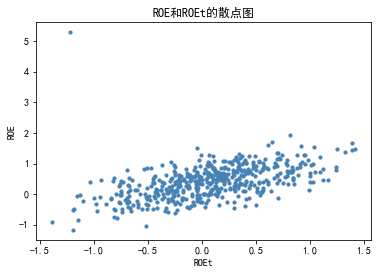

In [8]:
# 散点图
# 绘制散点图
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 为了画图能够显示中文，否则中文会变成乱码。
plt.rcParams['axes.unicode_minus']=False  # 画图正常显示负号

plt.scatter(x = data2002.ROEt, # 指定散点图的x轴数据
            y = data2002.ROE, # 指定散点图的y轴数据
            s = 10,  # 指定散点图点的大小
            c = 'steelblue') # 指定散点图中点的颜色
# 添加x轴和y轴标签
plt.xlabel('ROEt')
plt.ylabel('ROE')
# 添加标题
plt.title('ROE和ROEt的散点图')
# 显示图形
plt.show()

## 相关分析

In [9]:
# NOTE
data.corr()

,year,ROEt,ATO,PM,LEV,GROWTH,PB,ARR,INV,ASSET,ROE
year,1.000000,-0.008522,0.002179,0.004613,0.067745,-0.051161,0.079774,-0.038328,0.033245,0.031804,-0.037798
ROEt,-0.008522,1.000000,0.044154,0.097517,-0.246938,0.042447,-0.225358,-0.072549,-0.029289,0.136143,0.571646
ATO,0.002179,0.044154,1.000000,-0.271664,-0.035780,0.004386,-0.054330,-0.116588,0.105438,0.069282,0.033027
PM,0.004613,0.097517,-0.271664,1.000000,-0.146390,0.025565,-0.056361,-0.402270,-0.097302,0.023362,0.091275
LEV,0.067745,-0.246938,-0.035780,-0.146390,1.000000,-0.028151,0.746345,0.059813,0.036031,-0.019070,-0.297254
GROWTH,-0.051161,0.042447,0.004386,0.025565,-0.028151,1.000000,-0.018986,-0.034048,0.043191,-0.029855,0.098837
PB,0.079774,-0.225358,-0.054330,-0.056361,0.746345,-0.018986,1.000000,0.001873,-0.025658,-0.188374,-0.236556
ARR,-0.038328,-0.072549,-0.116588,-0.402270,0.059813,-0.034048,0.001873,1.000000,-0.051356,-0.086433,-0.090626
INV,0.033245,-0.029289,0.105438,-0.097302,0.036031,0.043191,-0.025658,-0.051356,1.000000,0.021881,-0.020789
ASSET,0.031804,0.136143,0.069282,0.023362,-0.019070,-0.029855,-0.188374,-0.086433,0.021881,1.000000,0.085186


**NOTE**

> `data.corr()`和`data.head()`这样的写法只会输出结果，不会保存结果。
>如果，比如说要保存相关系数的结果，则用`result = data.corr()`这样的写法，然后再用`result`或者`print(result)`查看即可。

## 线性回归模型

In [10]:
# 一元线性回归 （x = ROEt, y = ROE）
# NOTE
model1 = smf.ols("ROE ~ ROEt", 
            data2002).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     179.9
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           3.10e-35
Time:                        20:30:21   Log-Likelihood:                -328.19
No. Observations:                 500   AIC:                             660.4
Df Residuals:                     498   BIC:                             668.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3738      0.021     17.734      0.0

**NOTE**
> `smf.ols()`是用了`import statsmodels.formula.api as smf`之后，调用这个模块下的`ols()`函数。
>如果你设置的缩写是其它的，那么调用时就要用自己设置的缩写。
>或者如果没有设置缩写，就要用全名调用。这也是为什么会设置缩写，更加简洁。

In [11]:
# 多元线性回归 （x = ROEt+ATO+PM+LEV+GROWTH+PB+ARR+INV+ASSET, y = ROE）
model2 = smf.ols("ROE ~ ROEt + ATO + PM + LEV + GROWTH + PB + ARR + INV + ASSET", 
            data2002).fit()
model2.summary()  
#  请品一品用print()和没用print()的区别

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROE   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     24.79
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           4.24e-35
Time:                        20:30:21   Log-Likelihood:                -311.46
No. Observations:                 500   AIC:                             642.9
Df Residuals:                     490   BIC:                             685.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4544      0.528      0.860      0.390      -0.584       1.492
ROEt           0.4875      0.041     11.875      0.000       0.407       0.568
ATO           -0.0147      0.048     -0.309      0.758      -0.108       0.079
PM             0.0788      0.133      0.592      0.554      -0.183       0.341
LEV           -0.0397      0.011     -3.770      0.000      -0.060      -0.019
GROWTH         0.0199      0.010      2.068      0.039       0.001       0.039
PB             0.0033      0.003      0.954      0.341      -0.004       0.010
ARR           -0.0260      0.024     -1.069      0.285      -0.074       0.022
INV           -0.0198      0.168     -0.118      0.906      -0.351       0.311
ASSET         -0.0031      0.025     -0.125      0.901      -0.052       0.046
==============================================================================
Omnibus:                      439.894   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33004.079
Skew:                           3.341   Prob(JB):                         0.00
Kurtosis:                      42.237   Cond. No.                         552.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 模型诊断(画图)

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

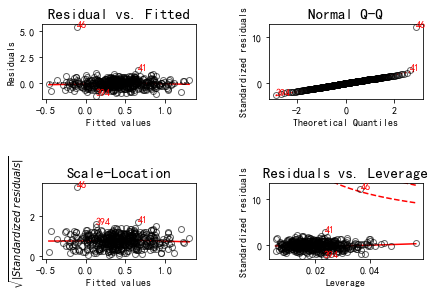

In [12]:
lmdiag.plot(model2)

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

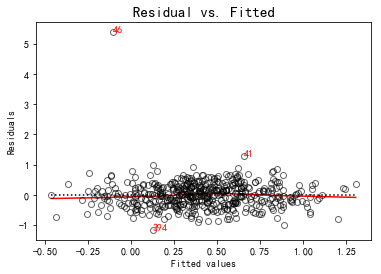

In [13]:
# 也可以单独画图
lmdiag.resid_fit(model2)  

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

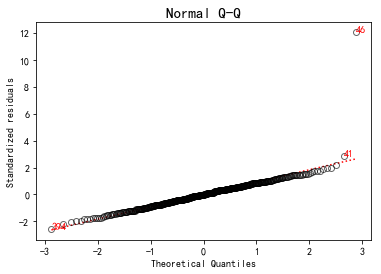

In [14]:
lmdiag.q_q(model2)

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

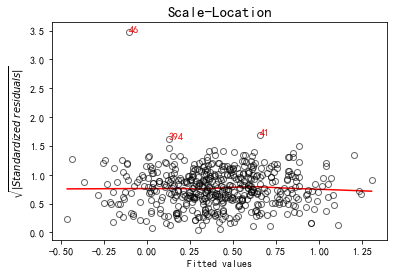

In [15]:
lmdiag.scale_loc(model2)

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

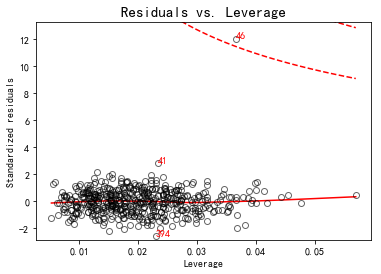

In [16]:
lmdiag.resid_lev(model2)

**NOTE**
>细心的小伙伴应该发现了，Python画出的图，标出的异常值点和书上用R画图标出的点不同。
>比如书上的异常点是第**47**个，而Python画图显示第**46**个。那么这是为什么呢？  
>
>因为Python的Index是从0开始的。也就是说我们在R或者Excel里面的第1行，在Python里面就是第0行。
>

## 异常值删除

In [17]:
# 参考书上，删除第46个值
# NOTE
data2002_a = data2002.drop([46])

**NOTE**
>这里是用pandas删除行，删除了第46行。  
>如果是删除列，可以用`dataframe.drop(['column_name'], axis=1)`

In [18]:
# 再次回归
model3 = smf.ols("ROE ~ ROEt + ATO + PM + LEV + GROWTH + PB + ARR + INV + ASSET", 
            data2002_a).fit()
print(model3.summary()) 

                            OLS Regression Results                            
Dep. Variable:                    ROE   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     40.01
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           2.63e-53
Time:                        20:30:29   Log-Likelihood:                -223.57
No. Observations:                 499   AIC:                             467.1
Df Residuals:                     489   BIC:                             509.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5615      0.444      1.266      0.2

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

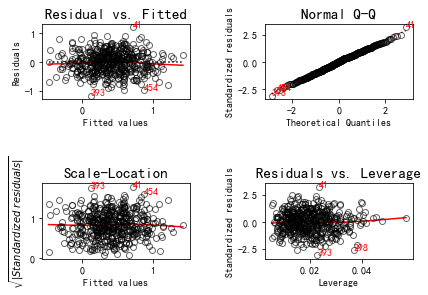

In [19]:
# 再次诊断
lmdiag.plot(model3)


## 共线性诊断

In [20]:
# NOTE
y, X = dmatrices( 'ROE ~ ROEt + ATO + PM + LEV + GROWTH + PB + ARR + INV + ASSET', 
                  data = data2002_a, return_type= 'dataframe')

vif = pd.DataFrame()  # 构造空的数据框
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,670.886077,Intercept
1,1.092696,ROEt
2,1.151425,ATO
3,1.395851,PM
4,2.699114,LEV
5,1.004474,GROWTH
6,2.629386,PB
7,1.279575,ARR
8,1.020351,INV
9,1.089989,ASSET


**NOTE**

>1. 看到这里用了双引号和单引号，python里面双引号和单引号功能是一样的，几乎没啥区别。
>在转义时有一点点区别。比如`print("let's go")`和`print('let\'s go')`是一样的，但是`print('let's go')`是会报错的。
>
>2. 这里可以看到R里面共线性就`vif(model)`就搞定，Python里还挺复杂。也可能是我没找到更好更简洁的代码哈。

**NOTE**  
以下两步暂时省略，有时间再补。  
1.变量选择 AIC  
2.变量选择 BIC

原因有二：
>1.跑这个python代码比R代码复杂很多，建议还是用R处理吧！  
>2.我自己也没跑过，不熟悉，没有找到AIC或BIC做逐步回归的包，需要自己写函数。
>有需要请自行百度吧~或者之后我再补下。



## 预测
用基于2002年数据建立的模型预测2003年的数据

In [21]:
# 预测值
true = data2003['ROE']
predict1 = model3.predict(data2003)

In [22]:
# 误差值= 真实值-预测值
resid0 = true - data2003['ROEt']
resid1 = true - predict1

In [23]:
# 求平均误差（误差的均值）
# NOTE
resid_result = abs(pd.DataFrame(list(zip(resid0, resid1)))) 
resid_result.mean()

0    0.415732
1    0.294452
dtype: float64

**NOTE**
>1. `abs()`函数，求绝对值
>2. `pd.DataFrame(list(zip(series1, series2)))`将Series(数组)转为DataFrame(数据框)。

**SUMMARY**

>1. 没啥好说的，这章很简单，其实很多代码和R有异曲同工之妙的。
>2. 主要有几点：  
>2.1 安装、导入相关的模块  
>2.2 一些基本函数的用法  
>2.3 利用pandas读取数据（本章是txt文件）  
>2.4 数据框（`pd.Dataframe`）的基本用法，做描述性统计等等  
>2.5 利用matplotlib画图